In [10]:
def compute_f1_scores(pred_pt, gold_pt, verbose=True):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred = 0, 0, 0

    for i in range(len(pred_pt)):
        n_gold += len(gold_pt[i])
        n_pred += len(pred_pt[i])

        for t in pred_pt[i]:
            if t in gold_pt[i]:
                n_tp += 1

    if verbose:
        print(
            f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}"
        )

    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (
        precision + recall) if precision != 0 or recall != 0 else 0
    scores = {
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'accuracy': n_tp / n_gold * 100
    }

    return scores

def dict_to_list(aspect_list, sentiment_elements):
    tuples = []
    for aspect in aspect_list:
        tuple = []
        for key in sentiment_elements:
            tuple.append(aspect[key])
        tuples.append(tuple)
    return tuples

In [11]:
import json
import numpy as np
f1_scores_all = {}

for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        model = "gemma3_4b"
        for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            try:
                with open(f"./predictions/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                   data = json.load(f)
            except FileNotFoundError:
                continue
            
            sentiment_elements = list(data[0]["gold"][0].keys())
            
            preds = [dict_to_list(example["predicted"], sentiment_elements) for example in data]
            golds = [dict_to_list(example["gold"], sentiment_elements) for example in data]

            scores = compute_f1_scores(preds, golds, verbose=False)
            f1_scores.append(scores["f1"])
            k_list.append(k)

        f1_scores_all[f"{dataset_name}_{task}"] = {"f1": f1_scores, "k": k_list}

In [12]:
f1_scores_all

{'rest16_tasd': {'f1': [34.850863422291994,
   40.87677725118483,
   47.26854514088556,
   44.12607449856733,
   48.15025611838361,
   48.71060171919771,
   47.44399770246985,
   48.137535816618914,
   49.94206257242178,
   50.80275229357798,
   51.549942594718715],
  'k': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
 'rest16_acd': {'f1': [66.18942731277532,
   70.32569360675512,
   70.96004770423376,
   70.40094339622642,
   74.61988304093568,
   73.35766423357664,
   75.35545023696683,
   75.92267135325133,
   71.34363852556478,
   72.53396337861784,
   75.52870090634441],
  'k': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
 'rest16_asqp': {'f1': [14.8619957537155,
   30.0530347672363,
   30.514488468361918,
   30.70588235294118,
   30.913348946135827,
   31.76265270506108,
   35.83138173302108,
   34.696261682243,
   33.812535940195524,
   34.39122908251587,
   34.82298316889146],
  'k': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
 'flightabsa

In [13]:
# Calculate average F1 scores across all datasets for each task and k value
f1_scores_avg = {}

for task in ["acd", "tasd", "asqp"]:
    f1_avg = []
    k_avg = []
    
    # Get all k values that have data for this task
    all_k_values = set()
    for dataset in ["rest16", "flightabsa", "coursera", "hotels"]:
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "k" in f1_scores_all[key]:
            all_k_values.update(f1_scores_all[key]["k"])
    
    # Sort k values
    all_k_values = sorted(list(all_k_values))
    
    for k in all_k_values:
        f1_values_for_k = []
        
        # Collect F1 scores for this k value across all datasets
        for dataset in ["rest16", "flightabsa", "coursera", "hotels"]:
            key = f"{dataset}_{task}"
            if key in f1_scores_all and "k" in f1_scores_all[key] and "f1" in f1_scores_all[key]:
                k_list = f1_scores_all[key]["k"]
                f1_list = f1_scores_all[key]["f1"]
                
                # Find the index of this k value
                if k in k_list:
                    idx = k_list.index(k)
                    f1_values_for_k.append(f1_list[idx])
        
        # Calculate average if we have data
        if f1_values_for_k:
            avg_f1 = np.mean(f1_values_for_k)
            f1_avg.append(avg_f1)
            k_avg.append(k)
    
    f1_scores_avg[f"avg_{task}"] = {"f1": f1_avg, "k": k_avg}

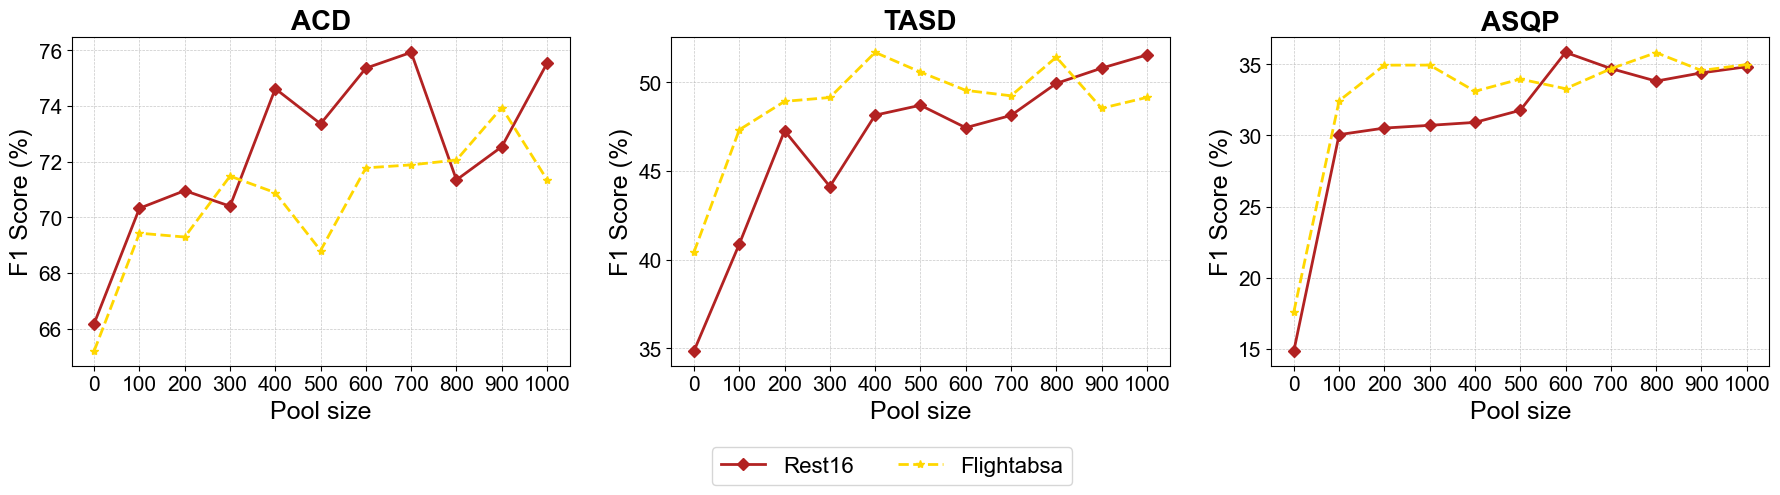

In [14]:
import matplotlib.pyplot as plt

# Set a professional style with Arial font
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Define colors and line styles for better distinction
colors = ['firebrick', 'gold', 'lightseagreen', 'purple']  # Custom colors for datasets
line_styles = ['-', '--', '-.', ':']

# Define markers for each dataset
markers = {
    "rest16": 'D',      # diamond
    "flightabsa": '*',  # star
    "hotels": '^',      # triangle
    "coursera": 'x'     # x
}

for i, task in enumerate(tasks):
    ax = axes[i]
    
    # Plot individual datasets
    for j, dataset in enumerate(datasets):
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "f1" in f1_scores_all[key] and len(f1_scores_all[key]["f1"]) > 0:
            label = f"{dataset.capitalize()}"
            marker = markers[dataset]
            ax.plot(f1_scores_all[key]["k"], f1_scores_all[key]["f1"], 
                    label=label, color=colors[j], linestyle=line_styles[j], linewidth=2, marker=marker, markersize=6)
    
    # Plot average line
    # avg_key = f"avg_{task}"
    # if avg_key in f1_scores_avg and "f1" in f1_scores_avg[avg_key] and len(f1_scores_avg[avg_key]["f1"]) > 0:
    #     ax.plot(f1_scores_avg[avg_key]["k"], f1_scores_avg[avg_key]["f1"], 
    #             label="Average", color='black', linestyle='-', linewidth=3, marker='s', markersize=8)
    
    # Set ticks for x-axis
    ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels([f'{int(x * 1000)}' for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
    
    # Add grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Titles and labels
    ax.set_title(f'{task.upper()}', fontsize=20, fontweight='bold')
    ax.set_xlabel('Pool size', fontsize=18)
    ax.set_ylabel('F1 Score (%)', fontsize=18)
    
    # Increase tick label size
    ax.tick_params(axis='both', labelsize=15)

# Collect handles and labels for common legend
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates
unique_labels = list(dict.fromkeys(labels))  # Preserve order
unique_handles = [handles[labels.index(label)] for label in unique_labels]

# Add common legend below the plots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=5, fontsize=16, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [15]:
import pandas as pd

# Pool-Größen als Integer (0, 100, ..., 1000)
k_values = [int(k * 1000) for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Erstelle MultiIndex für Spalten: (Task, Dataset)
columns = pd.MultiIndex.from_tuples([(task.upper(), dataset.capitalize()) for task in tasks for dataset in datasets])

# Erstelle DataFrame
df_performance = pd.DataFrame(index=k_values, columns=columns, dtype=str)

# Fülle die Daten aus f1_scores_all
for task in tasks:
    for dataset in datasets:
        key = f"{dataset}_{task}"
        if key in f1_scores_all and "f1" in f1_scores_all[key] and "k" in f1_scores_all[key]:
            k_list = f1_scores_all[key]["k"]
            f1_list = f1_scores_all[key]["f1"]
            for i, k in enumerate(k_list):
                k_int = int(k * 1000)
                if k_int in df_performance.index:
                    df_performance.loc[k_int, (task.upper(), dataset.capitalize())] = f"{f1_list[i]:.2f}"

# Für jede Spalte den größten Wert mit \textbf{} umschließen
for col in df_performance.columns:
    column = df_performance[col]
    numeric_values = []
    for val in column:
        if pd.notna(val) and val != '':
            try:
                numeric_values.append(float(val))
            except ValueError:
                pass
    if numeric_values:
        max_val = max(numeric_values)
        for idx in df_performance.index:
            val = df_performance.loc[idx, col]
            if pd.notna(val) and val != '':
                try:
                    if float(val) == max_val:
                        df_performance.loc[idx, col] = f"\\textbf{{{val}}}"
                except ValueError:
                    pass

In [16]:
with open('performance_latex/muster.txt', 'r') as f:
    content = f.read()

for row in df_performance.itertuples(index=False):
    for value in row:
        content = content.replace("xxxx", str(value), 1)

with open('performance_latex/out.txt', 'w') as f:
    f.write(content)

In [17]:
times_all = {}
for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        model = "gemma3_4b"
        for k in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            try:
                with open(f"./predictions/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                   data = json.load(f)
            except FileNotFoundError:
                data = []
            
            times = [example["time"] for example in data]
            times_all[f"{dataset_name}_{task}_{k}"] = np.mean(times)
            

/Users/msnilshellwig/miniconda3/envs/env_nils_hellwig/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/msnilshellwig/miniconda3/envs/env_nils_hellwig/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
import pandas as pd

# Create a list to hold the data
data = []

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]
k_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for task in tasks:
    for k in k_values:
        for dataset in datasets:
            key = f"{dataset}_{task}_{k}"
            if key in times_all and not np.isnan(times_all[key]):
                data.append({"task": task.upper(), "k": int(k * 1000), "dataset": dataset.capitalize(), "time": times_all[key]})

# Create DataFrame
df_times = pd.DataFrame(data)

# Calculate average time per task and k over all datasets
df_avg = df_times.groupby(['task', 'k'])['time'].mean().reset_index()

# Pivot the DataFrame
df_pivot = df_avg.pivot(index='k', columns='task', values='time')

# Reorder columns to ACD, TASD, ASQP
#df_pivot = df_pivot[['ACD', 'TASD', 'ASQP']]

# add column for average time across tasks
df_pivot['avg'] = df_pivot.mean(axis=1)

# Display the pivoted DataFrame
df_pivot

task,ACD,ASQP,TASD,avg
k,,,,
0,1.147741,1.482567,1.492892,1.374400
100,1.290162,1.995871,1.554235,1.613422
200,1.285504,1.974388,1.576080,1.611990
300,1.288227,1.993798,1.585818,1.622614
400,1.300950,1.975921,1.587001,1.621291
500,1.304142,1.996022,1.576351,1.625505
600,1.291840,1.982351,1.582050,1.618747
700,1.282833,1.982456,1.588458,1.617916
800,1.308393,1.993185,1.583017,1.628198
